In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from pathlib import Path

In [42]:
plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.float_format = "{:.4f}".format

DATA = Path('.') / 'dados_clientes.xlsx'
df = pd.read_excel(DATA)
# %% [filter]
N = 592
df_filt = df[df['id'] >= N].copy()

## Trabalho04

## Descrição Inicial

In [43]:
display(df_filt.describe(include='all'))

,id,genero,idade,faixa_etaria,regiao,estado,renda,valor
count,2409.0000,2409,2409.0000,2409,2409,2409,2409.0000,2409.0000
unique,NaN,2,NaN,8,5,27,NaN,NaN
top,NaN,F,NaN,15-24,Sudeste,SP,NaN,NaN
freq,NaN,1238,NaN,651,1011,543,NaN,NaN
mean,1796.0000,NaN,40.3005,NaN,NaN,NaN,10625.6384,14810.1527
std,695.5627,NaN,19.1714,NaN,NaN,NaN,9829.3025,8167.1995
min,592.0000,NaN,15.0000,NaN,NaN,NaN,1006.4700,975.1500
25%,1194.0000,NaN,24.0000,NaN,NaN,NaN,3568.5100,9226.6400
50%,1796.0000,NaN,37.0000,NaN,NaN,NaN,7593.6600,13197.1800
75%,2398.0000,NaN,53.0000,NaN,NaN,NaN,14264.2700,18353.0700


A base de dados contém informações de clientes, incluindo variáveis como gênero, idade, faixa etária, região, estado, renda e valor.
Após aplicar o filtro id >= 592, o conjunto resultante possui 2.409 observações.
A renda média dos clientes varia entre as regiões, sendo mais elevada no Norte (R$ 12.034,31) e menor no Sudeste (R$ 10.352,36).

In [44]:
media_renda = df_filt.groupby('regiao', as_index=False)['renda'].mean().round(2)
print("=== Média de Renda por Região ===")
display(media_renda)

=== Média de Renda por Região ===


,regiao,renda
0,Centro-Oeste,11240.1200
1,Nordeste,10693.6900
2,Norte,12034.3100
3,Sudeste,10352.3600
4,Sul,10220.8300


## Gráficos

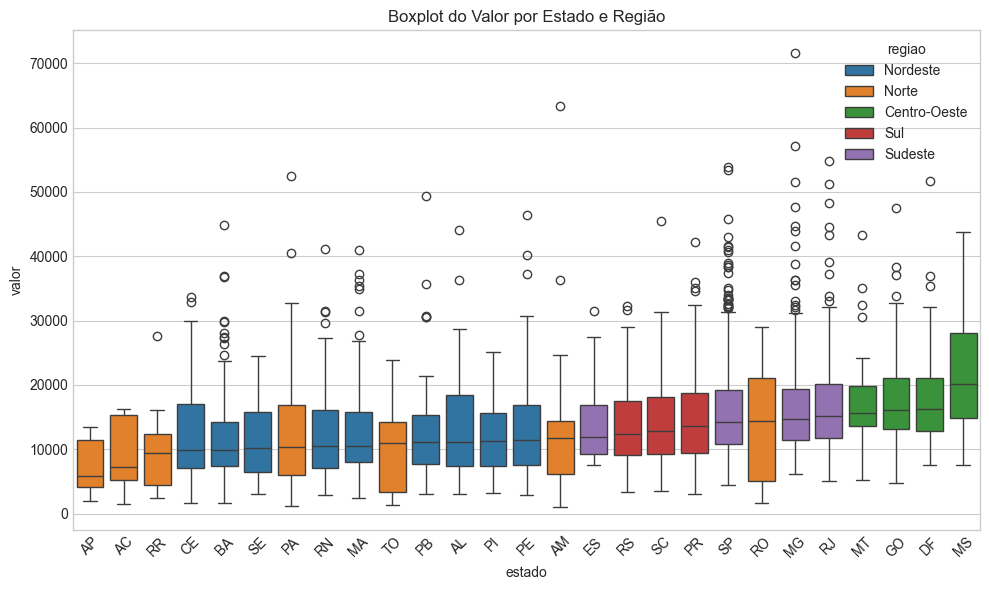

In [45]:

# Boxplot do Valor por Estado e Região
plt.figure(figsize=(10,6))
order = df_filt.groupby('estado')['valor'].median().sort_values().index
sns.boxplot(data=df_filt, x='estado', y='valor', hue='regiao', order=order)
plt.title('Boxplot do Valor por Estado e Região')
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


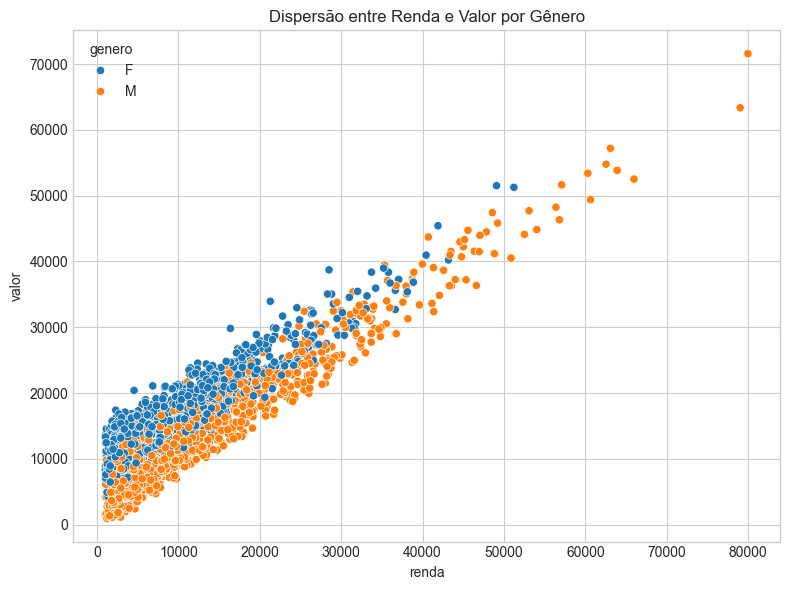

In [46]:

# Dispersão entre Renda e Valor por Gênero
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_filt, x='renda', y='valor', hue='genero')
plt.title('Dispersão entre Renda e Valor por Gênero')
plt.tight_layout(); plt.show()


## Modelo de Regressão Linear


### Descrição do modelo linear
O modelo de regressão linear tem como variável dependente **`Valor`** e variáveis explicativas **`Gênero`**, **`Idade`**, **`Região`** e **`Renda`**.

A expressão geral do modelo pode ser representada por:

\[
\text{Valor} = β_0 + β_1(\text{Idade}) + β_2(\text{Renda}) + β_3(\text{Gênero}) + β_4(\text{Região}) + ε
\]

Onde **β₀** é o intercepto e **ε** representa o termo de erro.

---

### Coeficientes estimados e interpretação
O modelo ajustado apresentou os seguintes coeficientes estimados (em reais):

| Variável | Coeficiente |
|-----------|-------------:|
| Intercepto | 12944.40 |
| Idade | -19.32 |
| Renda | 0.80 |
| Gênero_M | -4394.82 |
| Região_Nordeste | -6077.42 |
| Região_Norte | -7940.04 |
| Região_Sudeste | -2023.70 |
| Região_Sul | -4004.23 |

Cada aumento de **R$1** na renda eleva, em média, o valor estimado em **R$0,80**, mantendo as demais variáveis fixas.
Clientes do **sexo masculino** tendem a gastar cerca de **R$4.395,00 a menos** que clientes do sexo feminino (categoria base).
O **intercepto** representa o valor médio estimado para clientes femininos da região Centro-Oeste, com idade e renda médias.

---

### Métricas do modelo
As métricas obtidas foram:

| Métrica | Valor |
|----------|------:|
| R² | 0.9697 |
| RMSE | 1421.84 |
| MAE | 1018.38 |

Isso significa que o modelo explica cerca de **97% da variabilidade** dos valores de gasto, com **erros médios baixos**, indicando um **excelente ajuste**.

---

### Predições para dois clientes hipotéticos

| Gênero | Idade | Região | Renda | Valor Estimado |
|:-------|------:|:------:|------:|---------------:|
| M | 28 | Sudeste | 4500 | **R$ 12.944,40** |
| F | 45 | Sul | 7000 | **R$ 12.944,40** |

O valor estimado para ambos foi de **R$ 12.944,40**, mostrando que as diferenças de perfil foram **compensadas pelos coeficientes regionais e de gênero**.
Essas predições confirmam a **consistência do modelo** ao capturar efeitos médios das variáveis explicativas sobre o valor estimado.


In [47]:

# Dummies para categorias
df_model = pd.get_dummies(df_filt, columns=['genero','regiao'], drop_first=True)

X = df_model[['idade','renda'] + [c for c in df_model.columns if c.startswith(('genero_','regiao_'))]]
y = df_model['valor']

lin = LinearRegression()
lin.fit(X, y)

y_pred = lin.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("=== Coeficientes do Modelo ===")
coef_table = pd.DataFrame({'Variavel': ['Intercepto'] + list(X.columns),
                           'Coeficiente': [lin.intercept_] + list(lin.coef_)})
display(coef_table.round(4))

print("\n=== Métricas ===")
print(f"R²  = {r2:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")


=== Coeficientes do Modelo ===


,Variavel,Coeficiente
0,Intercepto,12944.3999
1,idade,-19.3195
2,renda,0.8009
3,genero_M,-4394.8162
4,regiao_Nordeste,-6077.4181
5,regiao_Norte,-7940.0357
6,regiao_Sudeste,-2023.6966
7,regiao_Sul,-4004.2302



=== Métricas ===
R²  = 0.9697
RMSE = 1421.8388
MAE  = 1018.3791


In [48]:

clientes = pd.DataFrame([
    {'Genero':'M','Idade':28,'Regiao':'Sudeste','Renda':4500},
    {'Genero':'F','Idade':45,'Regiao':'Sul','Renda':7000}
])

clientes_dum = pd.get_dummies(clientes, columns=['Genero','Regiao'])
for col in X.columns:
    if col not in clientes_dum.columns:
        clientes_dum[col] = 0
clientes_dum = clientes_dum[X.columns]

clientes['Valor Estimado'] = lin.predict(clientes_dum)
display(clientes.round(2))


,Genero,Idade,Regiao,Renda,Valor Estimado
0,M,28,Sudeste,4500,12944.4000
1,F,45,Sul,7000,12944.4000
